In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sympy as sp
from scipy.integrate import cumulative_simpson as cumsimp
from scipy.linalg import cholesky, solve_triangular, solve



In [2]:
import dickandballs as db

In [3]:
some_kernel = db.Kernel('SE', sigma=1,l=1)

kernel code works with unequal length arrays

In [139]:
x2 = np.linspace(0, 50, 5)
x1 = np.array([1,40])
f1 = (np.array([0.033545,1/3]))

In [5]:
sigma = 1
l = 1
r = np.subtract.outer(x1, x2)
K = sigma ** 2 * np.exp(-r / (2 * l ** 2))

In [6]:
my_kernel = db.Kernel('SE', sigma=sigma, l=l)

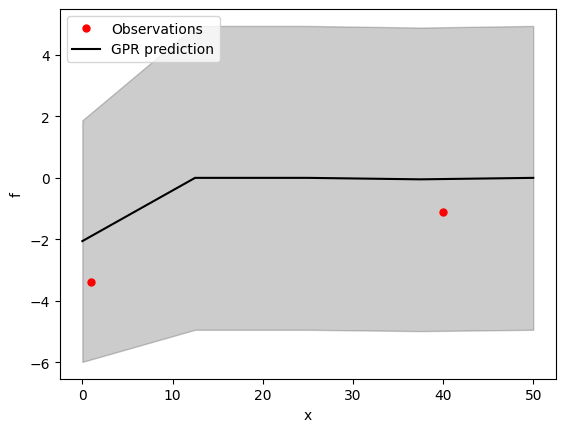

In [77]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# the squared exponential kernel is RBF kernel
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

gpr = GaussianProcessRegressor(kernel=kernel)
# fit the model to the residuals
gpr.fit(x1.reshape(-1, 1), f1.reshape(-1, 1))

f2, sigma = gpr.predict(x2.reshape(-1,1), return_std=True)

# add the polynomial to the GPR predictions

plt.figure()
plt.plot(x1, f1, 'r.', markersize=10, label='Observations')
plt.plot(x2, f2, '-', color='black', label='GPR prediction')
plt.fill_between(x2.ravel(), f2 - 1.96 * sigma, f2 + 1.96 * sigma, alpha=0.2, color='k')
plt.xlabel('x')
plt.ylabel('f')
plt.legend()
plt.show()

In [146]:
def fit(x1, x2, f, kernel):

    from scipy.linalg import cho_solve,cho_factor

    kernel = kernel
    K_11 = kernel.compute(x1)
    K_12 = kernel.compute(x1, x2)
    K_22 = kernel.compute(x2)

    K_11[np.diag_indices_from(K_11)] += 1e-10

    L = cholesky(K_11, lower=True)
    y = cho_solve((L,True), f)
 
    alpha = cho_solve((L,False),y)

    mean_star = K_12.T @ alpha
    
    v = cho_solve((L,True), K_12)
    print(v)
    cov_star = K_22 - (v.T @ v)

    bruh = v.T@v
    eigvals_bruh = np.linalg.eigvals(bruh)
    print("Eigenvalues of v^T v:", eigvals_bruh)
    assert np.all(eigvals_bruh > 0), "v^T v is not positive definite!"

    print(np.linalg.eigvals(bruh))
    np.linalg.cholesky(bruh)

    return mean_star, cov_star

In [147]:
mean_star, cov_star = fit(x1,x2,f1,my_kernel)

[[6.06530660e-01 3.14190660e+02 1.62754791e+05 8.43090692e+07
  4.36731791e+10]
 [2.06115211e-19 1.06770409e-16 5.53085138e-14 2.86504709e-11
  1.48413335e-08]]
Eigenvalues of v^T v: [-2.62144000e+05+0.00000000e+00j  1.90735368e+21+0.00000000e+00j
 -1.97714979e+00+0.00000000e+00j  8.67539912e-05+1.33912403e-05j
  8.67539912e-05-1.33912403e-05j]


AssertionError: v^T v is not positive definite!

In [102]:
K_11 = my_kernel.compute(x1)
K_12 = my_kernel.compute(x1, x2)
K_22 = my_kernel.compute(x2)

L = cholesky(K_11, lower=True)
y = solve_triangular(L, f1, lower=True)
alpha = solve_triangular(L.T, y, lower=False)
mean_star = K_12.T @ alpha

v = solve_triangular(L, K_12, lower=True)
cov_star = K_22 - (v.T @ v)

In [105]:
bruh

array([[3.67879441e-01, 1.90566268e+02, 9.87157710e+04, 5.11360354e+07,
        2.64891221e+10],
       [1.90566268e+02, 9.87157710e+04, 5.11360354e+07, 2.64891221e+10,
        1.37217050e+13],
       [9.87157710e+04, 5.11360354e+07, 2.64891221e+10, 1.37217050e+13,
        7.10801915e+15],
       [5.11360354e+07, 2.64891221e+10, 1.37217050e+13, 7.10801915e+15,
        3.68204508e+18],
       [2.64891221e+10, 1.37217050e+13, 7.10801915e+15, 3.68204508e+18,
        1.90734657e+21]])

In [104]:
bruh = v.T@v
np.linalg.eigvals(bruh)

array([ 0.00000000e+00,  1.90735368e+21,  5.50022212e-02, -3.38754755e-02,
        2.60296858e-16])

In [ ]:


bruh = v.T@v
eigvals_bruh = np.linalg.eigvals(bruh)
print("Eigenvalues of v^T v:", eigvals_bruh)
assert np.all(eigvals_bruh > 0), "v^T v is not positive definite!"

print(np.linalg.eigvals(bruh))
np.linalg.cholesky(bruh)

Eigenvalues of v^T v: [ 0.00000000e+00  1.90735368e+21  5.50022212e-02 -3.38754755e-02
  2.60296858e-16]


AssertionError: v^T v is not positive definite!

In [85]:
def fit2(x1, x2, f, kernel):

    kernel = kernel
    Σ11 = kernel.compute(x1)
    Σ12 = kernel.compute(x1, x2)
    Σ22 = kernel.compute(x2)

    solved = solve(Σ11, Σ12, assume_a = 'pos').T

    print(solved)
    # Compute posterior mean
    μ2 = solved @ f
    # Compute the posterior covariance
    Σ2 = Σ22 - (solved @ Σ12)

    return μ2, Σ2

In [98]:
Σ11 = my_kernel.compute(x1)
Σ12 = my_kernel.compute(x1, x2)
Σ22 = my_kernel.compute(x2)

solved = (np.linalg.inv(Σ11) @ Σ12).T
print(solved.shape)
# Compute posterior mean
μ2 = solved @ f1
print(μ2.shape)
# Compute the posterior covariance
xxxx = solved @ Σ12
Σ2 = Σ22 - xxxx



(5, 2)
(5,)


In [99]:
np.linalg.eigvals(xxxx)


array([ 0.00000000e+00 +0.j       ,  1.61130349e+21 +0.j       ,
       -5.38349671e-04+22.7431775j, -5.38349671e-04-22.7431775j,
        3.81480570e-06 +0.j       ])

In [78]:
xxxx.shape

(5, 5)

In [80]:
Σ11

array([[1.00000000e+00, 2.94267566e+08],
       [3.39826782e-09, 1.00000000e+00]])

In [91]:
np.linalg.cholesky(xxxx)

LinAlgError: Matrix is not positive definite

In [92]:
f2 = np.random.multivariate_normal(μ2, Σ2)
sigma2 = np.sqrt(np.diag(Σ2))

/tmp/ipykernel_22021/1761889715.py:1: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  f2 = np.random.multivariate_normal(μ2, Σ2)
/tmp/ipykernel_22021/1761889715.py:2: RuntimeWarning: invalid value encountered in sqrt
  sigma2 = np.sqrt(np.diag(Σ2))


In [25]:
kern_x2= my_kernel.compute(x2)

In [26]:
f2 = np.random.multivariate_normal(mean_star, cov_star)
sigma2 = np.sqrt(np.diag(cov_star))

/tmp/ipykernel_22021/3534796776.py:1: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  f2 = np.random.multivariate_normal(mean_star, cov_star)
/tmp/ipykernel_22021/3534796776.py:2: RuntimeWarning: invalid value encountered in sqrt
  sigma2 = np.sqrt(np.diag(cov_star))


<Axes: >

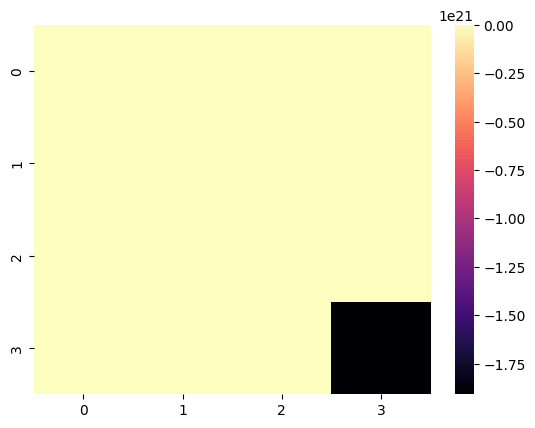

In [27]:
sns.heatmap(cov_star, cmap='magma')

In [46]:
f2

array([-8.07461088e-01, -3.35927185e+03, -1.39754506e+07, -5.81415345e+10])

In [47]:
sigma2

array([0.7950601,       nan,       nan,       nan])

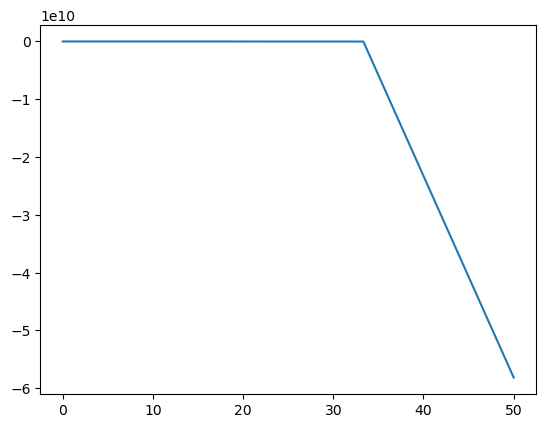

In [48]:
plt.plot(x2, f2)
plt.fill_between(x2, f2 - sigma2, f2 + sigma2, color='gray', alpha=0.2, label='Error')
